In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta 

# Load Data

In [2]:
test = pd.read_csv('data/email_best_send_time_test.csv')
train = pd.read_csv('data/email_best_send_time_train.csv')

train_clean_text = pd.read_csv('train_clean_subject.csv').fillna('')
test_clean_text = pd.read_csv('test_clean_subject.csv').fillna('')
train = train.merge(train_clean_text, 'left', on='MailID')
test = test.merge(test_clean_text, 'left', on='MailID')

In [3]:
train

,MailID,Subject,MailBoxID,ContactID,TimeZone,SentOn,Opened,subject_re,clean_subject,super_clean_subject
0,C278C72C-63D6-4D42-B5A6-455FA2C80D7C,"""Cold emails not converting?""",9F1BAD1D-0370-4200-0045-08D70B884EBA,8977EFF2-DCAD-4E29-B29C-BE55449D24A2,"""(UTC+00:00) Dublin, Edinburgh, Lisbon, London""",9/9/20 11:34,0,False,Cold emails not converting?,coldemailsnotconverting
1,F5CA7090-9A73-4197-9923-C094B140C4D1,"""Webnar: Cold emails not converting?""",7FCE4E75-9A26-4EE6-7806-08D6CEFA3BFA,22A565BC-DC52-4CF5-8852-5C343F477F54,"""(UTC-06:00) Central Time (US & Canada)""",9/9/20 11:35,0,False,Webnar: Cold emails not converting?,webnarcoldemailsnotconverting
2,B4837C83-9425-4C77-907E-E3B318A5F0F0,"""Cold emails not converting?""",9F1BAD1D-0370-4200-0045-08D70B884EBA,00E3A137-053F-4838-AB6F-4A8F6F52969A,"""(UTC+00:00) Dublin, Edinburgh, Lisbon, London""",9/9/20 11:38,0,False,Cold emails not converting?,coldemailsnotconverting
3,204546C3-073D-418E-98BD-E5553B339686,"""Webnar: Cold emails not converting?""",7FCE4E75-9A26-4EE6-7806-08D6CEFA3BFA,9A13D123-10AA-46BF-B5C9-7199074DDD71,"""(UTC-05:00) Eastern Time (US & Canada)""",9/9/20 11:40,0,False,Webnar: Cold emails not converting?,webnarcoldemailsnotconverting
4,F28E3C17-0000-4549-9153-5896688E7581,"""Webnar: Cold emails not converting?""",7FCE4E75-9A26-4EE6-7806-08D6CEFA3BFA,FA770B61-2BB3-44EB-A064-0F80CAD8E753,"""(UTC-06:00) Central Time (US & Canada)""",9/9/20 11:43,0,False,Webnar: Cold emails not converting?,webnarcoldemailsnotconverting
...,...,...,...,...,...,...,...,...,...,...
100139,2EA3A30E-D8DB-44E3-A8B3-CA7D9BA2633C,"""RE: Revenue Inbox | Sync integration for Sale...",FBCA1245-7297-41A8-1AB0-08D7856F3B8E,FEB418B4-D3FF-4B84-8703-E8A71478C11C,"""(UTC+00:00) Dublin, Edinburgh, Lisbon, London""",7/1/21 11:48,1,True,Revenue Inbox | Sync integration for Salesforce,revenueinboxsyncintegrationfor
100140,114E23DD-5386-40FA-B7C8-AFD80628FE4D,"""RE: Hi Jeffrey!""",2B68B3E2-ADF7-4D0F-8F59-645C8CDF6EA6,748DFA05-47E9-4FB8-9EA3-0B5619CD6CB6,"""(UTC-05:00) Eastern Time (US & Canada)""",7/1/21 11:48,0,True,Hi PERSON!,hiperson
100141,6EE9027F-E9E5-476C-B1F4-F9A6433B5DDF,"""testy test""",66C24EAB-51C7-4B5F-EFCA-08D6D3CCF2FF,E315C9A4-E5C4-484F-9278-6347BE3C2CD1,NaN,7/1/21 11:55,0,False,testy test,testytest
100142,DE170985-95AB-47B6-A077-B7B4BD6C6FF3,"""RE: Charlotte, thanks for signing up to Reven...",FBCA1245-7297-41A8-1AB0-08D7856F3B8E,793680C5-DDFD-41A8-9194-61B1AFC9D9F2,"""(UTC+00:00) Dublin, Edinburgh, Lisbon, London""",7/1/21 11:55,0,True,"PERSON, thanks for signing up to Revenue Inbox",personthanksforsigninguptoreve


# Preprocessing + Feature

### fix dtype

In [4]:
def fix_dtype_df(df):
    df['SentOn'] = pd.to_datetime(df['SentOn'])
    df.loc[df['TimeZone'].notna(), 'TimeZone'] = df.loc[df['TimeZone'].notna(), 'TimeZone'].apply(lambda x: x[5:8]).astype(float)
    return df

### time features

In [5]:
def add_time_feature(df):
    df['receive_on'] = df['SentOn'] + pd.to_timedelta(df['TimeZone'].fillna(0), unit='hour')
    df['receive_on_hour'] = df['receive_on'].dt.hour.astype(np.int8)
    df['receive_on_weekday'] = df['receive_on'].dt.weekday.astype(np.int8)
    df['receive_on_month'] = df['receive_on'].dt.month.astype(np.int8)
    df['TimeZone'] = df['TimeZone'].fillna(25)
    return df

### text features

In [6]:
def add_text_feature(df):
    df['len_subject'] = df['Subject'].apply(len)
    df['len_clean_subject'] = df['super_clean_subject'].apply(len)
    df['len_super_clean_subject'] = df['super_clean_subject'].apply(len)

    df['subject_person']  = df['clean_subject'].str.contains('PERSON')
    df['subject_company']  = df['clean_subject'].str.contains('_COMPANY_')
    df['subject_revenue_grid']  = df['clean_subject'].str.lower().str.contains(r'revenue ?grid', regex=True)
    df['subject_salesforce']  = df['clean_subject'].str.lower().str.contains('salesforce')
    df['subject_revenue_inbox']  = df['clean_subject'].str.lower().str.contains('revenue inbox')
    return df

### add features

In [7]:
train = fix_dtype_df(train)
train = add_time_feature(train)
train = add_text_feature(train)

test = fix_dtype_df(test)
test = add_time_feature(test)
test = add_text_feature(test)

# OOF Mean traget by column prediction as feature

In [8]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

In [9]:
oof_pred_list = [['ContactID'],
                 ['Subject'],
                 ['clean_subject'],
                 ['ContactID', 'MailBoxID'],
                 ['ContactID', 'Subject'],
                 ['ContactID', 'clean_subject'],
                 ['ContactID', 'receive_on_hour'],
                 ['ContactID', 'receive_on_weekday'],
                 ['ContactID', 'receive_on_month'],
                 
                 ['MailBoxID', 'Subject'],
                 ['MailBoxID', 'clean_subject'],
                 ['MailBoxID', 'receive_on_hour'],
                 ['MailBoxID', 'receive_on_weekday'],
                 ['MailBoxID', 'receive_on_month'],
                 
                 ['Subject', 'receive_on_hour'],
                 ['Subject', 'receive_on_weekday'],
                 ['Subject', 'receive_on_month'],
                 
                 ['clean_subject', 'receive_on_hour'],
                 ['clean_subject', 'receive_on_weekday'],
                 ['clean_subject', 'receive_on_month'],
                ]

In [10]:
for cols in oof_pred_list:
    new_col = 'oof_mean_'+'__'.join(cols)
    train[new_col] = train[cols].astype(str).apply('__'.join, axis=1)
    test[new_col] = test[cols].astype(str).apply('__'.join, axis=1)
    
    col2target = train.groupby(new_col)['Opened'].mean()
    test[new_col] = test[new_col].map(col2target).fillna(-1)
    
    oof_meen_prediction = pd.Series(index=train.index, dtype=float)
    for train_idx, val_idx in cv.split(train, train['Opened']):
        fold_train = train.iloc[train_idx]
        fold_val = train.iloc[val_idx]
        fold_col2target = fold_train.groupby(new_col)['Opened'].mean()
        fold_prediction = fold_val[new_col].map(fold_col2target).fillna(-1)
        oof_meen_prediction.iloc[val_idx] = fold_prediction
    
    train[new_col] = oof_meen_prediction.round(2)

# X, y

In [11]:
train_cols = ['TimeZone',
              'receive_on_hour', 'receive_on_weekday', 'receive_on_month',
              'len_subject', 'len_clean_subject', 'len_super_clean_subject', 
              'subject_re', 'subject_person', 'subject_company', 'subject_revenue_grid', 'subject_salesforce', 'subject_revenue_inbox', 
              'oof_mean_Subject', 'oof_mean_clean_subject', 'oof_mean_ContactID__MailBoxID', 'oof_mean_ContactID__Subject', 'oof_mean_ContactID__clean_subject',
              'oof_mean_ContactID__receive_on_hour', 'oof_mean_ContactID__receive_on_weekday', 'oof_mean_ContactID__receive_on_month', 'oof_mean_MailBoxID__Subject',
              'oof_mean_MailBoxID__clean_subject', 'oof_mean_MailBoxID__receive_on_hour', 'oof_mean_MailBoxID__receive_on_weekday', 'oof_mean_MailBoxID__receive_on_month',
              'oof_mean_Subject__receive_on_hour', 'oof_mean_Subject__receive_on_weekday', 'oof_mean_Subject__receive_on_month', 'oof_mean_clean_subject__receive_on_hour',
              'oof_mean_clean_subject__receive_on_weekday', 'oof_mean_clean_subject__receive_on_month']

X = train[train_cols]
y = train['Opened']

X_test = test[train_cols]

# Validation

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score


def f1(true, pred, n=100):
    score = []
    for i in range(1, n):
        treshold = i/n
        score.append(f1_score(true, pred> treshold))

    treshold_i = np.argmax(score)
    return score[treshold_i], treshold_i/n

In [13]:
model = RandomForestClassifier(max_leaf_nodes=1024, max_features=0.4, min_samples_leaf=2, min_samples_split=5, max_depth=32, random_state=42)
pred_model = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:,1]
pred_model = pd.Series(pred_model, train.index)
score, treshold = f1(y, pred_model)
score, treshold

(0.7579478082255731, 0.38)

# Prediction

In [14]:
model.n_estimators = 1000
model.n_jobs = -1
model.fit(X, y)
prediction = model.predict_proba(X_test)[:,1]

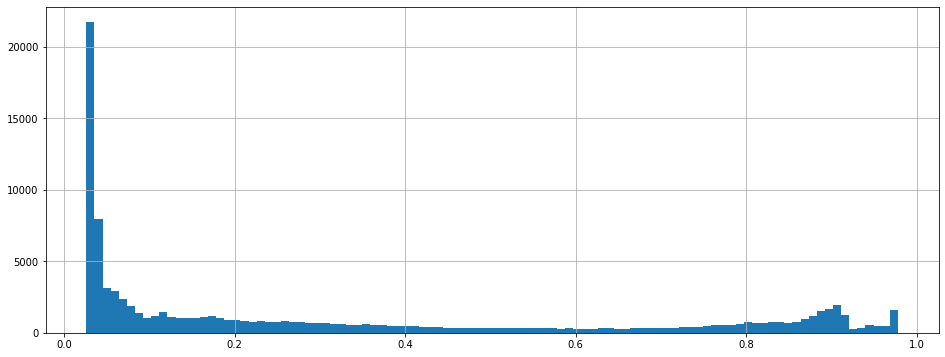

In [15]:
pd.Series(prediction).hist(bins=100, figsize=(16, 6));

In [16]:
sub = pd.read_csv('data/email_best_send_time_sample_submission.csv')
sub['Opened'] = (prediction > treshold).astype(int)
sub.to_csv('sub_rf_final.csv', index=False)
sub

,MailID,Opened
0,43F37954-24F6-4F2E-BEC7-B6F0103307A0,0
1,1CCDF694-BB52-4EB4-8C5A-669BB4D0339E,0
2,EDC436A8-B8B0-4B57-B003-54FF51C09E82,0
3,27378C7B-B5EB-4E48-93ED-EE2F16B83DB8,0
4,6F5CC7DC-BDA8-4FCB-992C-1550C8C6DFC1,0
...,...,...
100107,7AD61EF8-B9FB-4F4F-9395-9C776C87F958,0
100108,5A65EF61-BDF6-482C-B163-29580509D25B,0
100109,F96CAD07-CF84-4899-961F-17DC5EE96F03,1
100110,61F73A0D-8731-410E-AC49-84C3BDECDB73,0


In [17]:
sub['Opened'].mean()

0.33340658462521977

In [18]:
train['Opened'].mean()

0.31730308355967407